In [1]:
import os
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2
import tensorflow_addons as tfa

In [76]:
from winreg import HKEY_LOCAL_MACHINE
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import math

np.random.seed(50)



In [3]:
from tensorflow.keras import layers

with open (r'D:\Github Repos\ECE1512\-ECE1512_2022W_ProjectRepo_StephanieDiNunzio\Project A\Project_A_Supp\MNIST1D.pkl', 'rb') as fp:
    dataset = pickle.load(fp)

train_data = dataset['x']
train_labels = dataset['y']
test_data = dataset['x_test']
test_labels = dataset['y_test']
spatial_map = dataset['t']
templates = dataset['templates']

train_data.shape = (4000,40,1)

##Task1-Question1
weight_decay = 5e-4
model = Sequential()
#Your code starts from here
batch_size = 64 
model.add(layers.Conv1D(25,5,strides=1,padding='same',activation='relu',input_shape=(40,1)))
#model.add(layers.Conv1D(25,5,strides=1,padding='same',activation='relu'))
model.add(layers.Conv1D(25,3,strides=1,padding='same',activation='relu'))
model.add(layers.Conv1D(25,3,strides=1,padding='same',activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(10,activation='softmax'))


In [4]:
##Task1-Question2

#Your code 

optimizer = tensorflow.keras.optimizers.SGD(learning_rate=0.01)
loss = keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

##

In [5]:
##Task1-Question3.a

#Your code


model.fit(x=train_data, y=train_labels,
          batch_size=batch_size, 
          epochs=200, 
          validation_split=0)

##

Epoch 1/200
63/63 [==============================] - 3s 3ms/step - loss: 2.2941 - accuracy: 0.0938
Epoch 2/200
63/63 [==============================] - 0s 2ms/step - loss: 2.2655 - accuracy: 0.1192
Epoch 3/200
63/63 [==============================] - 0s 2ms/step - loss: 2.2254 - accuracy: 0.1632
Epoch 4/200
63/63 [==============================] - 0s 2ms/step - loss: 2.1588 - accuracy: 0.2072
Epoch 5/200
63/63 [==============================] - 0s 2ms/step - loss: 2.0464 - accuracy: 0.2247
Epoch 6/200
63/63 [==============================] - 0s 2ms/step - loss: 1.9127 - accuracy: 0.2445
Epoch 7/200
63/63 [==============================] - 0s 2ms/step - loss: 1.8100 - accuracy: 0.2767
Epoch 8/200
63/63 [==============================] - 0s 2ms/step - loss: 1.7451 - accuracy: 0.2945
Epoch 9/200
63/63 [==============================] - 0s 2ms/step - loss: 1.7029 - accuracy: 0.3147
Epoch 10/200
63/63 [==============================] - 0s 2ms/step - loss: 1.6687 - accuracy: 0.3282
Epoch 11/

In [106]:
def perturb_img_1d(img, perturb, sec_size):
    mask = np.zeros(img.shape)[0]
    not_masked = np.where(perturb == 1)[0]
    for i, val in enumerate(not_masked):
        if val != 0:
            for j in range(sec_size):
                mask[sec_size*i + j] = 1
    perturbed_img = img*mask[:,np.newaxis]
    return perturbed_img

def perturb_img(img, perturb, segs):
    mask = np.zeros(segs.shape)
    not_masked = np.where(perturb == 1)[0]
    for i in not_masked:
        mask[segs == i] = 1
    perturbed_img = copy.deepcopy(img)
    perturbed_img = perturbed_img*mask[:,:,np.newaxis]
    return perturbed_img


def LIME_img(img, model, label, num_perturb=300, kernel_w=0.25, num_feats=10):
    superpixels = skimage.segmentation.quickshift(img, kernel_size=4,max_dist=200, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    skimage.io.imshow(skimage.segmentation.mark_boundaries(img, superpixels))
    perturbs = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    preds = []
    for i in perturbs:
        perturbed_img = perturb_img(img, i, superpixels)
        pred = model.predict(perturbed_img[np.newaxis,:,:,:])
        preds.append(pred)
    preds = np.array(preds)
    orig_img = np.ones(num_superpixels)[np.newaxis,:]
    dists = sklearn.metrics.pairwise_distances(perturbs, orig_img, metric='cosine').ravel()
    weights = np.sqrt(np.exp(-(dists**2)/kernel_w**2))
    lime_model = LinearRegression()
    lime_model.fit(x=perturbs, y=preds[:,:,label], sample_weight=weights)
    c = lime_model.coef_[0]
    top_feats = np.argsort(c)[-num_feats:]
    mask = np.zeros(num_superpixels) 
    mask[top_feats]= True 
    skimage.io.imshow(perturb_img(img,mask,superpixels) )

def LIME_1d(img, model, label, num_perturb=300, sec_size=4, kernel_w=0.25, num_feats=4):
    num_superpixels = math.ceil(img.shape[1]/sec_size)
    perturbs = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    preds = []
    for i in perturbs:
        perturbed_img = perturb_img_1d(img, i, sec_size)
        pred = model.predict(perturbed_img)
        preds.append(pred)
    preds = np.array(preds)
    orig_img = np.ones(num_superpixels)[np.newaxis,:]
    dists = sklearn.metrics.pairwise_distances(perturbs, orig_img, metric='cosine').ravel()
    weights = np.sqrt(np.exp(-(dists**2)/kernel_w**2))
    lime_model = LinearRegression()
    lime_model.fit(perturbs, preds[:,:,label], weights)
    c = lime_model.coef_[0]
    top_feats = np.argsort(c)[-num_feats:]
    mask_superpixel = np.zeros(num_superpixels) 
    mask_superpixel[top_feats]= True 
    mask = np.zeros(img.shape[1])
    for i, val in enumerate(mask_superpixel):
        if val != 0:
            for j in range(sec_size):
                mask[sec_size*i + j] = 1
    perturbed_img = img*mask[:,np.newaxis]
    
    c_exp = np.zeros(img.shape[1])
    for i, c_i in enumerate(c):
        for j in range(sec_size):
                c_exp[sec_size*i + j] = c_i

    return c_exp, perturbed_img[0] 




In [108]:
x_test = dataset['x_test']
y_test = dataset['y_test']
x_test.shape = (1000,40)

index = int(np.floor(np.random.rand()*1000))
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
label = y_test[index]



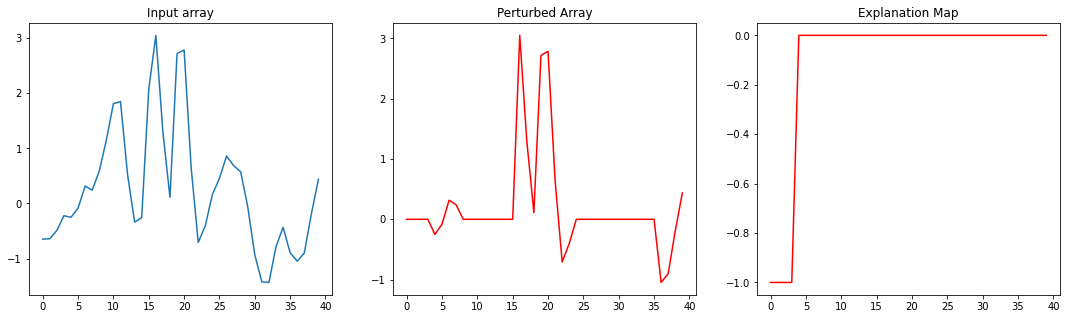

In [110]:
c_exp, perturbed_img = LIME_1d(input, model, label, num_perturb=300, sec_size=4, kernel_w=0.4, num_feats=4)

In [ ]:
plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(c_exp, 'r')
plt.title('Explanation Map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot(perturbed_img[0], 'r')
plt.title('Perturbed Array')